In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold



In [4]:
# read dataframe
combined = pd.read_pickle('../../combined')

# Train a SVM model 

In [5]:
# remove NaN in output antibiotics
def noNullAntibiotics(antibiotics):
    df = combined.loc[pd.isnull(combined[antibiotics + '_ris']) == 0]
    return df

# plot_learning_curve from sklearn examples
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    #return plt

# a simple svm
def trainSVM(df, antibiotics):
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :406], df[antibiotics + '_ris'], test_size=0.2, random_state=0)
    
    # choose estimator (our model)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    # cross validation
    skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
    cv = skf.split(X_train, y_train)
   
    # tune hyperparameters
    gammas = np.logspace(-6, -1, 10)
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammas,
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    classifier = GridSearchCV(estimator=clf, cv=cv, param_grid=tuned_parameters)
    classifier.fit(X_train.values, np.asarray(y_train))
    
    # print rankings
    rankDf = pd.DataFrame.from_dict(classifier.cv_results_)
    rankDf = rankDf.sort_values('rank_test_score')
    print(rankDf.head())
    
    # plot learning curve
    title = antibiotics +' Learning Curves ' 
    estimator = svm.SVC(kernel='linear', gamma=classifier.best_estimator_.gamma) #put the best parameters in
    plot_learning_curve(estimator, title, X_train.values, np.asarray(y_train), cv=skf)
    plt.show()
    # final evaluation with out test set: default: accuracy
    print('best params:', classifier.best_params_, 'best scorer', classifier.scorer_, 'best gamma', classifier.best_estimator_.gamma)
    print('classifier score', classifier.score(X_test, y_test))
    

# combine everything
def antiToSVM(antibiotics):
    df = noNullAntibiotics(antibiotics)
    trainSVM(df, antibiotics)
    

    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
21       0.008312         0.003793         0.906542          0.906527     100   
30       0.007080         0.002415         0.906542          0.906527    1000   
24       0.004918         0.001963         0.906542          0.908842     100   
23       0.005147         0.002065         0.906542          0.906527     100   
22       0.005926         0.002612         0.906542          0.906527     100   

    param_gamma param_kernel  \
21  3.59381e-06          rbf   
30        1e-06          rbf   
24   0.00016681          rbf   
23  4.64159e-05          rbf   
22  1.29155e-05          rbf   

                                               params  rank_test_score  \
21  {'C': 100, 'gamma': 3.5938136638e-06, 'kernel'...                1   
30       {'C': 1000, 'gamma': 1e-06, 'kernel': 'rbf'}                1   
24  {'C': 100, 'gamma': 0.00016681005372, 'kernel'...                1   
23  {'C': 100, 'gamma': 

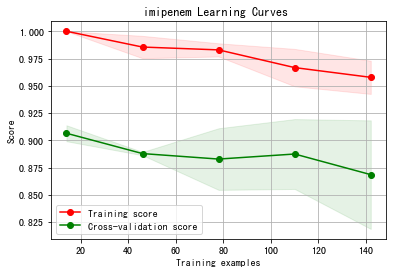

best params: {'C': 1, 'gamma': 0.00016681005372000591, 'kernel': 'rbf'} best scorer <function _passthrough_scorer at 0x7feadd9cc048> best gamma 0.00016681005372
classifier score 0.888888888889


In [6]:
antiToSVM('imipenem')

In [7]:
combined['imipenem_ris'].value_counts()

R                   149
S                   114
I                     5
cannot determine      0
Name: imipenem_ris, dtype: int64

    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
39       0.005635         0.002065         0.976959          0.995402    1000   
19       0.006142         0.002571         0.976959          0.995402      10   
29       0.006510         0.002880         0.976959          0.995402     100   
43       0.003489         0.001292         0.967742          0.995402    1000   
41       0.003396         0.001262         0.967742          0.995402      10   

   param_gamma param_kernel                                      params  \
39         0.1          rbf  {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}   
19         0.1          rbf    {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}   
29         0.1          rbf   {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}   
43         NaN       linear             {'C': 1000, 'kernel': 'linear'}   
41         NaN       linear               {'C': 10, 'kernel': 'linear'}   

    rank_test_score  split0_test_score  split0_train_score  sp

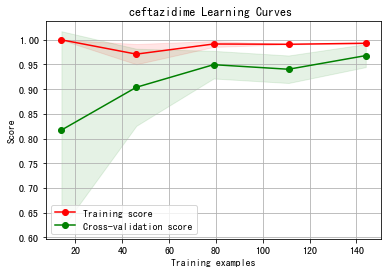

best params: {'C': 10, 'gamma': 0.10000000000000001, 'kernel': 'rbf'} best scorer <function _passthrough_scorer at 0x7feadd9cc048> best gamma 0.1
classifier score 0.909090909091


In [8]:
antiToSVM('ceftazidime')

In [9]:
antiToSVM('levofloxacin')

    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
26       0.006231         0.002369         0.939815          0.967593     100   
34       0.005721         0.002141         0.939815          0.962963    1000   
18       0.006198         0.002363         0.935185          0.967593      10   
17       0.005865         0.002350         0.935185          0.960648      10   
19       0.007176         0.002792         0.930556          0.981481      10   

   param_gamma param_kernel  \
26  0.00215443          rbf   
34  0.00016681          rbf   
18   0.0278256          rbf   
17  0.00774264          rbf   
19         0.1          rbf   

                                               params  rank_test_score  \
26  {'C': 100, 'gamma': 0.00215443469003, 'kernel'...                1   
34  {'C': 1000, 'gamma': 0.00016681005372, 'kernel...                1   
18  {'C': 10, 'gamma': 0.0278255940221, 'kernel': ...                3   
17  {'C': 10, 'gamma': 0.00774

ValueError: The number of classes has to be greater than one; got 1

In [10]:
combined['levofloxacin_ris'].value_counts()

R                   156
S                   111
I                     3
cannot determine      0
Name: levofloxacin_ris, dtype: int64

In [11]:
antiToSVM('ciprofloxacin')

/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
26       0.005778         0.001976         0.967593          0.986111     100   
34       0.005429         0.002213         0.967593          0.986111    1000   
27       0.005753         0.002176         0.962963          0.995386     100   
18       0.005821         0.002157         0.958333          0.986111      10   
40       0.004962         0.002029         0.958333          0.995386       1   

   param_gamma param_kernel  \
26  0.00215443          rbf   
34  0.00016681          rbf   
27  0.00774264          rbf   
18   0.0278256          rbf   
40         NaN       linear   

                                               params  rank_test_score  \
26  {'C': 100, 'gamma': 0.00215443469003, 'kernel'...                1   
34  {'C': 1000, 'gamma': 0.00016681005372, 'kernel...                1   
27  {'C': 100, 'gamma': 0.00774263682681, 'kernel'...                3   
18  {'C': 10, 'gamma': 0.02782

/home/hermuba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


ValueError: The number of classes has to be greater than one; got 1

## interpretation:

the learning vurve suggesting high variance
[reference](https://drive.google.com/drive/folders/0BweONCgBYqEqeHkyT1MwZjF4UUE)

# try SVM kernal: rbf

In [ ]:
np.logspace(-6, -1, 10)

In [ ]:
# remove NaN in output antibiotics
def noNullAntibiotics(antibiotics):
    df = combined.loc[pd.isnull(combined[antibiotics + '_ris']) == 0]
    return df

# plot_learning_curve from sklearn examples
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    #return plt

# a simple svm
def trainSVMrbf(df, antibiotics):
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :406], df[antibiotics + '_ris'], test_size=0.8, random_state=0)
    
    # choose estimator (our model)
    clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
    # cross validation
    skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
    cv = skf.split(X_train, y_train)
   
    # tune hyperparameters
    gammas = np.logspace(-6, -1, 10)
    classifier = GridSearchCV(estimator=clf, cv=cv, param_grid=dict(gamma=gammas))
    classifier.fit(X_train.values, np.asarray(y_train))
    
    # plot learning curve
    title = antibiotics +' Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %classifier.best_estimator_.gamma
    estimator = svm.SVC(kernel='linear', gamma=classifier.best_estimator_.gamma) #put the best parameters in
    plot_learning_curve(estimator, title, X_train.values, np.asarray(y_train), cv=skf)
    plt.show()
    # final evaluation with out test set: default: accuracy
    print('classifier score', classifier.score(X_test, y_test))
    

# combine everything
def antiToSVMrbf(antibiotics):
    df = noNullAntibiotics(antibiotics)
    trainSVMrbf(df, antibiotics)

In [ ]:
antiToSVMrbf('levofloxacin')